## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [4]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

import torch
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy


In [642]:
incorrectos = np.load('incorrect_files.npy')

file= incorrectos[80]


image = RetreiveImage(file, verbose=True)


img_byte_array = CroppedImage(image, verbose=True)

client = vision.ImageAnnotatorClient()
content = img_byte_array.getvalue()
image = vision.Image(content=content)

response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})


Image has been read from google bucket.

Image has been cropped.


In [643]:
RetreiveImage(file, verbose=True)



Image has been read from google bucket.


In [644]:
def extract_vertices(bounding_box):
    vertices = []
    for vertex in bounding_box.vertices:
        vertices.append((vertex.x, vertex.y))
    return vertices

In [645]:
def rotate_image_and_transform_coordinates(image, coordinates, angle):

    angle = np.rad2deg(angle)

    # Calculate the transformation matrix.
    transform_matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)

    # Apply the transformation matrix to the coordinates.
    image = cv2.warpAffine(image, transform_matrix, (image.shape[1], image.shape[0]))

    transformed_coordinates = [(transform_matrix[:,:2] @ coordinates[i].T).T + transform_matrix[:,2] for i in range(len(coordinates))]

    return image, transformed_coordinates

def zero_printed_text(image, threshold=150, verbose=False):

    mask = np.zeros(image.shape, dtype=np.uint8)

    mask[(image>0) & (image<50)] = 1

    nx, ny = image.shape

    # mask[nx//6:4*nx//6, ny//6:5*ny//6] = 0 #havent worked this bit out yet

    dilated = cv2.dilate(mask, np.ones((9,9), np.uint8), iterations=1)



    return image * (1-dilated)

In [646]:

bounding_box = []
character = []

charno = 0

for a, page in enumerate(response.full_text_annotation.pages):
    for b, block in enumerate(page.blocks):

        for c, paragraph in enumerate(block.paragraphs):
            
            for d, word in enumerate(paragraph.words):
                for e, symbol in enumerate(word.symbols):
                    vertices = extract_vertices(symbol.bounding_box)

                    bounding_box.append(vertices)
                    character.append(symbol.text)

                    charno += 1

                    if charno==5: #after the 3 character crap
                        page_no = a
                        block_no = b
                        paragraph_no = c
                        word_no = d
                        symbol_no = e
                        


bounding_box = np.array(bounding_box)

print(character)

['M', 'L', 'L', '1', '5', '5', '0', '0', '1', '/', '2', '7', '/', '1', '3']


C:\Users\howards\AppData\Local\Temp\ipykernel_25028\1254189862.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


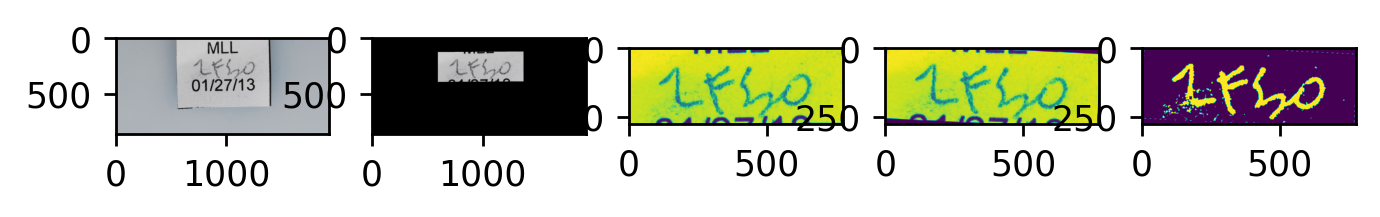

In [647]:
para_box = np.array(extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].bounding_box)) #this isnt extacting the whole id for some examples annoyingly. (because it doesnt think they;re part of the same word.)
    
decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)
frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR)
%matplotlib inline

padx = 100
pady = 60

#firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
adapted_para_box = para_box.copy()

x = np.argsort(para_box[:,0])
y = np.argsort(para_box[:,1])

adapted_para_box[x[:2],0] = para_box[x[:2],0] - padx
adapted_para_box[x[2:],0] = para_box[x[2:],0] + 1.2*padx

adapted_para_box[y[:2],1] = para_box[y[:2],1] - pady
adapted_para_box[y[2:],1] = para_box[y[2:],1] + pady

rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
mask1[rel_area] = 1

miny, maxy, minx, maxx = np.min(adapted_para_box[:,0]), np.max(adapted_para_box[:,0]), np.min(adapted_para_box[:,1]), np.max(adapted_para_box[:,1])


idx = para_box[:,1].argsort()[:2]
dx = para_box[idx[1],0] - para_box[idx[0],0]
dy = para_box[idx[1],1] - para_box[idx[0],1]

angle = np.arctan2(dy,dx)



fig,ax = plt.subplots(1,5,dpi=250)
ax[0].imshow(frame)
frame = frame*mask1[...,None] #mask the image

ax[1].imshow(frame)

frame = np.mean(frame, axis=2)
frame = frame[minx:maxx, miny:maxy]

ax[2].imshow(frame)

frame = rotate(frame, -angle, resize=False, ) #rotate the image
# frame = (1-frame) #invert and threshold.
# frame[frame < 0.5] = 0
# frame[frame !=0] = 1

ax[3].imshow(frame)


frame = zero_printed_text(frame, threshold = 150) #threshold needs to be found algorithmically.


hist = np.histogram(frame, bins=100)
peaks,_ = scipy.signal.find_peaks(hist[0], height=1000, distance=7)

if len(peaks) == 2:
    peak_handwriting = peaks[0]
    peak_background = peaks[1]

    thresh = hist[1][peak_background]/4  + 3*hist[1][peak_handwriting]/4 
else:
    thresh = frame.max()*0.85


frame[frame>thresh] = 0 
frame[frame!=0] = 1



ax[4].imshow(frame)
